In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# 1. Classification Neural Network

## 1.1 Prepare Data

In [2]:
# Make 1000 samples
n_samples = 1000

In [3]:
# Create datapoints (circles)
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [4]:
# Create dataframe
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})

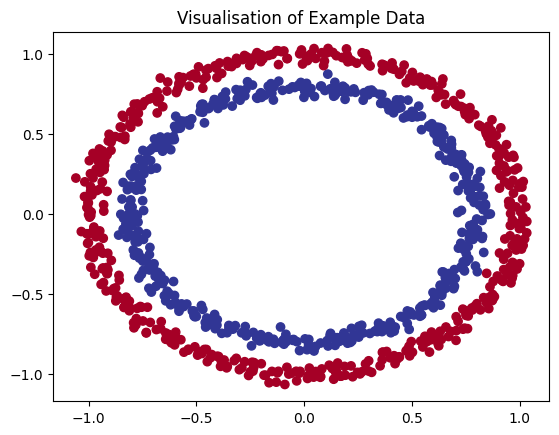

In [5]:
# Visualise Data
plt.scatter(x=circles['X1'],
            y=circles['X2'],
            c=circles['label'],
            cmap=plt.cm.RdYlBu)
plt.title('Visualisation of Example Data')
plt.show()

## 1.2 Transform Data

In [6]:
# Check shape
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

## 1.3 Split Data into Training and Testset

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [9]:
# Check data
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 1.4 Build Model

### Model

In [10]:
# set up code agnostic code so code could be run if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 3 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Non Linear Activation Function

    # 3. Define forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
# 4. Instantiate an instance of our model class and send to target device
model_1 = CircleModelV1().to(device)

### Loss Function and Optimizer

For classification we want to use binary cross entropy loss is you are faced with binary classification. Otherwise a possibility is categorical cross entropy loss.

In [12]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function build in
# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

c:\Users\lukas\anaconda3\envs\pytorch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.5 Train the Model

Going from raw logits to prediction probabilities to prediction labels

In [13]:
# Create random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set number of epochs
epochs = 1000

for epoch in range(epochs):
    # Set model in train mode
    model_1.train()

    # Forward Pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate the loss
    loss = loss_fn(y_logits, y_train)

    # Calculate accuracy on training data
    correct_train = (y_pred == y_train).sum().item()
    acc_train = correct_train / len(y_train)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation -> Loss backward
    loss.backward()

    # Step the optimizer
    optimizer.step()

    # Testing
    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        # Calculate accuracy on test data
        correct_test = (test_pred == y_test).sum().item()
        acc_test = correct_test / len(y_test)

    # Print out whats happening
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f} | Acc: {acc_train:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {acc_test: 2f}%")

Epoch 0 | Loss: 0.6966 | Acc: 0.50% | Test Loss: 0.6943 | Test Accuracy:  0.500000%
Epoch 100 | Loss: 0.6912 | Acc: 0.51% | Test Loss: 0.6902 | Test Accuracy:  0.530000%
Epoch 200 | Loss: 0.6890 | Acc: 0.55% | Test Loss: 0.6892 | Test Accuracy:  0.580000%
Epoch 300 | Loss: 0.6867 | Acc: 0.54% | Test Loss: 0.6880 | Test Accuracy:  0.525000%
Epoch 400 | Loss: 0.6836 | Acc: 0.55% | Test Loss: 0.6861 | Test Accuracy:  0.505000%
Epoch 500 | Loss: 0.6792 | Acc: 0.57% | Test Loss: 0.6829 | Test Accuracy:  0.525000%
Epoch 600 | Loss: 0.6725 | Acc: 0.65% | Test Loss: 0.6770 | Test Accuracy:  0.560000%
Epoch 700 | Loss: 0.6594 | Acc: 0.77% | Test Loss: 0.6628 | Test Accuracy:  0.720000%
Epoch 800 | Loss: 0.6344 | Acc: 0.87% | Test Loss: 0.6377 | Test Accuracy:  0.850000%
Epoch 900 | Loss: 0.5878 | Acc: 0.89% | Test Loss: 0.5947 | Test Accuracy:  0.865000%


## 1.6 Evaluate Model

In [16]:
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))